# Movie fMRI – Phase 2: Group mask & tSNR (run-02 only)

Dataset: **500 Days of Summer (run-02, sub-12/13/14/17/18)**

In this notebook I will:

- Load the run-02 BOLD data and the subject masks created in Phase 1.
- Build a **group-level brain mask** (intersection of all subject masks).
- Compute **temporal SNR (tSNR)** maps for each subject's run-02.
- Create a **group-average tSNR map** and basic summary statistics.

These results will help decide which subjects/runs are clean enough for later movie vs. music analyses.


In [ ]:
# Cell 2 – imports & paths

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib
from nilearn import image, masking, plotting


PROJECT_ROOT = Path(r"D:\4th sem\Neural Data Science\Final Project\project_root")
DATA_ROOT    = PROJECT_ROOT / "data"
DERIV_ROOT   = PROJECT_ROOT / "derivatives" / "movie"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT exists:", DATA_ROOT.exists())
print("DERIV_ROOT exists:", DERIV_ROOT.exists())


PROJECT_ROOT: D:\4th sem\Neural Data Science\Final Project\project_root
DATA_ROOT exists: True
DERIV_ROOT exists: True


In [2]:
# Cell 3 – locate run-02 BOLD images and the masks from Phase 1

bold_files = sorted(
    DATA_ROOT.glob("**/sub-*task-500daysofsummer_run-02_bold.nii*")
)

mask_files = sorted(
    DERIV_ROOT.glob("sub-* _run-02_mask.nii.gz".replace(" ", ""))
)

print("Found run-02 BOLD files:", len(bold_files))
for f in bold_files:
    print("  BOLD:", f.name)

print("\nFound run-02 masks:", len(mask_files))
for f in mask_files:
    print("  MASK:", f.name)

if len(bold_files) == 0:
    raise FileNotFoundError("No run-02 BOLD files found – check DATA_ROOT.")

if len(mask_files) != len(bold_files):
    print("\nWARNING: number of masks != number of BOLD files.")


Found run-02 BOLD files: 5
  BOLD: sub-12_task-500daysofsummer_run-02_bold.nii
  BOLD: sub-13_task-500daysofsummer_run-02_bold.nii
  BOLD: sub-14_task-500daysofsummer_run-02_bold.nii
  BOLD: sub-17_task-500daysofsummer_run-02_bold.nii
  BOLD: sub-18_task-500daysofsummer_run-02_bold.nii

Found run-02 masks: 5
  MASK: sub-12_run-02_mask.nii.gz
  MASK: sub-13_run-02_mask.nii.gz
  MASK: sub-14_run-02_mask.nii.gz
  MASK: sub-17_run-02_mask.nii.gz
  MASK: sub-18_run-02_mask.nii.gz


In [5]:
# Cell 4 – build a group-level mask (intersection of all run-02 masks)
# by first resampling all masks to a common reference grid.

if not mask_files:
    raise FileNotFoundError("No run-02 masks found in DERIV_ROOT.")

# Use the first mask as the reference grid
ref_mask_path = mask_files[0]
ref_mask_img = image.load_img(ref_mask_path)
print("Reference mask:", ref_mask_path.name, "shape:", ref_mask_img.shape)

resampled_masks = [ref_mask_img]

for mf in mask_files[1:]:
    m_img = image.load_img(mf)
    # If shape or affine differ, resample to the reference
    if (m_img.shape != ref_mask_img.shape) or not np.allclose(m_img.affine, ref_mask_img.affine):
        print("Resampling", mf.name, "to reference grid")
        m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
    else:
        print("Mask", mf.name, "already matches reference grid")
    resampled_masks.append(m_img)

# Now all masks are on the same grid → safe to intersect
group_mask_img = masking.intersect_masks(
    resampled_masks,
    threshold=1.0,   # voxels present in ALL subjects
    connected=True
)

group_mask_path = DERIV_ROOT / "group_run-02_mask_intersection.nii.gz"
group_mask_img.to_filename(group_mask_path)

print("Saved group mask to:", group_mask_path)


Reference mask: sub-12_run-02_mask.nii.gz shape: (64, 64, 40)
Resampling sub-13_run-02_mask.nii.gz to reference grid
Resampling sub-14_run-02_mask.nii.gz to reference grid
Resampling sub-17_run-02_mask.nii.gz to reference grid
Resampling sub-18_run-02_mask.nii.gz to reference grid


C:\Users\krant\AppData\Local\Temp\ipykernel_4084\22467101.py:19: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Users\krant\AppData\Local\Temp\ipykernel_4084\22467101.py:19: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Users\krant\AppData\Local\Temp\ipykernel_4084\22467101.py:19: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  m_img = image.resample_to_img(m_img, ref_mask_img, interpolation="nearest")
C:\Users\krant\AppData\Local\Temp\ipyk

Saved group mask to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\group_run-02_mask_intersection.nii.gz


C:\Users\krant\AppData\Local\Temp\ipykernel_4084\196606452.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  example_mean = image.mean_img(example_bold)


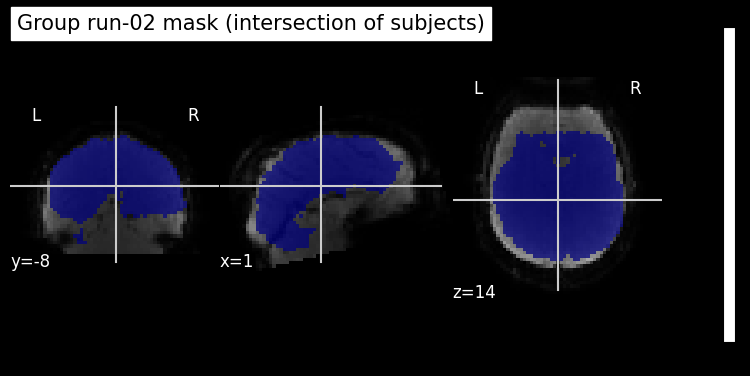

In [6]:
# Cell 5 – visualize the group-level mask on top of one subject's mean EPI

# use first subject as background
example_bold = image.load_img(bold_files[0])
example_mean = image.mean_img(example_bold)

plotting.plot_roi(
    group_mask_img,
    bg_img=example_mean,
    title="Group run-02 mask (intersection of subjects)"
)


In [14]:
# Cell 6 – compute tSNR maps per subject for run-02
# using each subject's own run-02 mask (native space)

from nilearn import masking
import numpy as np

# Map subject -> its run-02 mask
mask_dict = {}
for mf in mask_files:
    sub_id = mf.name.split("_")[0]   # "sub-12"
    mask_dict[sub_id] = mf

print("Subject -> mask mapping:")
for k, v in mask_dict.items():
    print(" ", k, "->", v.name)


def compute_tsnr_for_run_native(bold_path: Path, mask_path: Path, out_dir: Path):
    """
    Compute temporal SNR for one run using the subject's own mask.
    tSNR = mean(signal over time) / std(signal over time)
    """
    sub_id = bold_path.name.split("_")[0]
    print(f"\nComputing tSNR for {sub_id} ({bold_path.name})")
    print("  Using mask:", mask_path.name)

    img = image.load_img(bold_path)
    mask_img = image.load_img(mask_path)

    # Sanity check: if affine/shape differ a bit, resample mask to BOLD
    if (img.shape[:3] != mask_img.shape[:3]) or not np.allclose(img.affine, mask_img.affine):
        print("  Resampling mask to match BOLD grid")
        mask_img = image.resample_to_img(mask_img, img, interpolation="nearest")

    # Apply mask: result is (n_scans, n_voxels)
    data_2d = masking.apply_mask(img, mask_img)

    mean_ts = data_2d.mean(axis=0)
    std_ts  = data_2d.std(axis=0)

    tsnr_1d = np.divide(
        mean_ts,
        std_ts,
        out=np.zeros_like(mean_ts),
        where=std_ts > 0
    )

    # Back to 3D in this subject's native space
    tsnr_img = masking.unmask(tsnr_1d, mask_img)

    out_path = out_dir / f"{sub_id}_run-02_tsnr_native.nii.gz"
    tsnr_img.to_filename(out_path)
    print("  Saved tSNR map to:", out_path)

    median_tsnr = float(np.median(tsnr_1d))
    mean_tsnr   = float(np.mean(tsnr_1d))

    return {
        "subject": sub_id,
        "run": "run-02",
        "median_tsnr": median_tsnr,
        "mean_tsnr": mean_tsnr,
    }


tsnr_summaries = []

for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    if sub_id not in mask_dict:
        print(f"WARNING: no mask found for {sub_id}, skipping.")
        continue

    mask_path = mask_dict[sub_id]
    info = compute_tsnr_for_run_native(bold_path, mask_path, DERIV_ROOT)
    tsnr_summaries.append(info)

print("\nFinished computing native-space tSNR for", len(tsnr_summaries), "run-02 files.")


Subject -> mask mapping:
  sub-12 -> sub-12_run-02_mask.nii.gz
  sub-13 -> sub-13_run-02_mask.nii.gz
  sub-14 -> sub-14_run-02_mask.nii.gz
  sub-17 -> sub-17_run-02_mask.nii.gz
  sub-18 -> sub-18_run-02_mask.nii.gz

Computing tSNR for sub-12 (sub-12_task-500daysofsummer_run-02_bold.nii)
  Using mask: sub-12_run-02_mask.nii.gz
  Saved tSNR map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-12_run-02_tsnr_native.nii.gz

Computing tSNR for sub-13 (sub-13_task-500daysofsummer_run-02_bold.nii)
  Using mask: sub-13_run-02_mask.nii.gz
  Saved tSNR map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-13_run-02_tsnr_native.nii.gz

Computing tSNR for sub-14 (sub-14_task-500daysofsummer_run-02_bold.nii)
  Using mask: sub-14_run-02_mask.nii.gz
  Saved tSNR map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\sub-14_run-02_tsnr_native.nii.gz

Computing tSNR for sub-17 (sub-17_task-500daysofsummer_

C:\Users\krant\AppData\Local\Temp\ipykernel_4084\3462857569.py:5: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  example_mean = image.mean_img(example_bold)


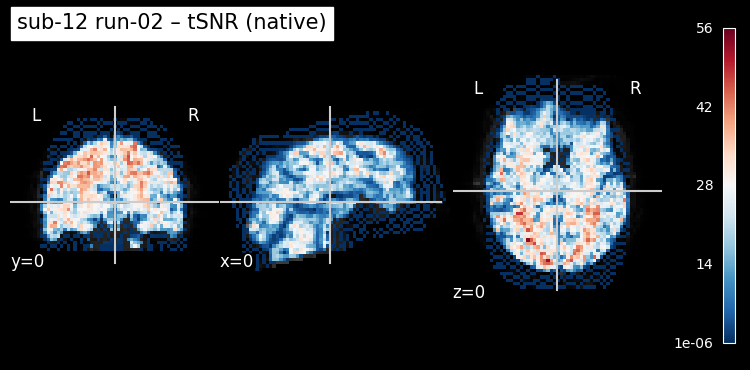

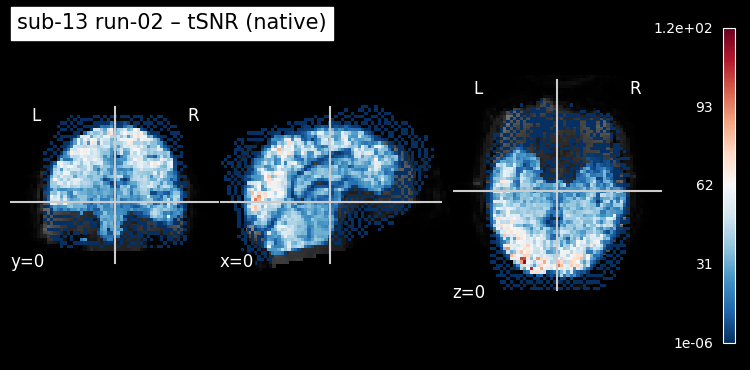

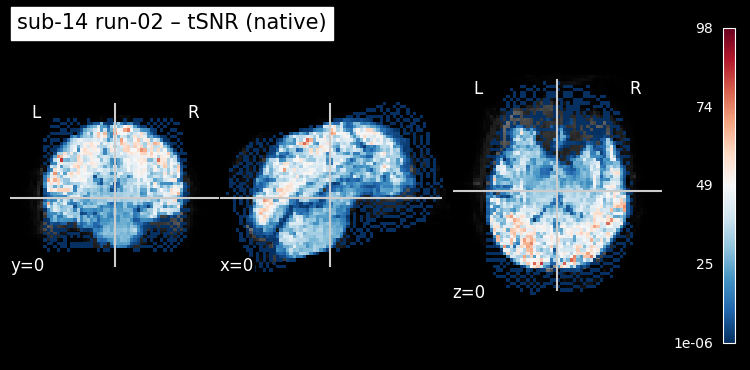

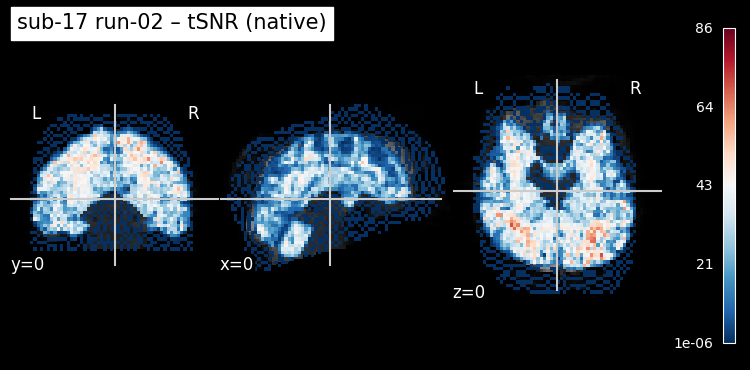

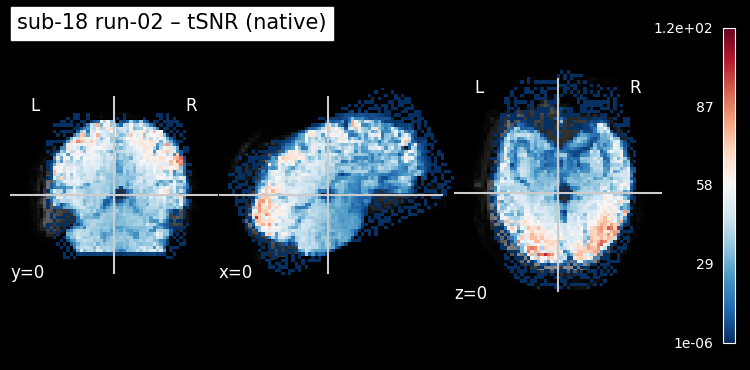

In [15]:
# Cell 7 – quick tSNR plots for each subject (native-space tSNR)

# Make sure we have a background mean image from one subject
example_bold = image.load_img(bold_files[0])
example_mean = image.mean_img(example_bold)

for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    tsnr_path = DERIV_ROOT / f"{sub_id}_run-02_tsnr_native.nii.gz"  # <-- match Cell 6

    if not tsnr_path.exists():
        print(f"tSNR file missing for {sub_id}: {tsnr_path.name}")
        continue

    tsnr_img = image.load_img(tsnr_path)

    plotting.plot_stat_map(
        tsnr_img,
        bg_img=example_mean,
        title=f"{sub_id} run-02 – tSNR (native)",
        display_mode="ortho",
        cut_coords=(0, 0, 0),
    )


C:\Users\krant\AppData\Local\Temp\ipykernel_4084\4291749730.py:27: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users\krant\AppData\Local\Temp\ipykernel_4084\4291749730.py:27: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users\krant\AppData\Local\Temp\ipykernel_4084\4291749730.py:27: FutureWarning: 'force_resample' will be set to 'True' by default in Nilearn 0.13.0.
Use 'force_resample=True' to suppress this warning.
  img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
C:\Users\krant\AppData\Local\Temp\i

Saved group-average tSNR map to: D:\4th sem\Neural Data Science\Final Project\project_root\derivatives\movie\group_run-02_tsnr_mean.nii.gz


,subject,run,median_tsnr,mean_tsnr
0,sub-12,run-02,23.464439,22.767160
1,sub-13,run-02,36.528072,36.334446
2,sub-14,run-02,32.797092,32.403362
3,sub-17,run-02,31.710621,31.228590
4,sub-18,run-02,39.964699,39.531033


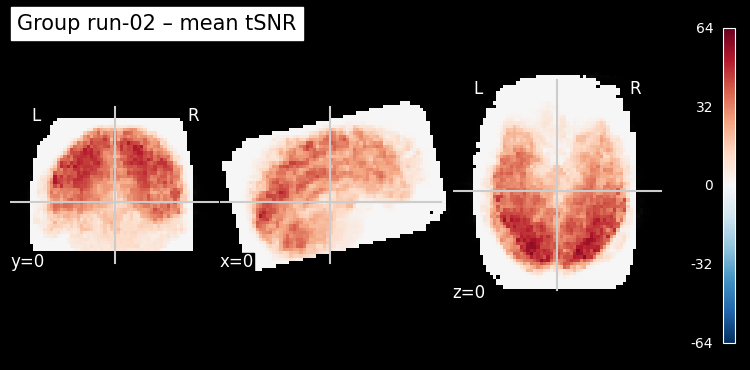

In [17]:
# Cell 8 – group-average tSNR map and subject summary table (native-space tSNR)

from nilearn import image
import numpy as np
import pandas as pd

# 1) Load all subject tSNR maps (native-space)
tsnr_imgs_native = []
for bold_path in bold_files:
    sub_id = bold_path.name.split("_")[0]
    tsnr_path = DERIV_ROOT / f"{sub_id}_run-02_tsnr_native.nii.gz"

    if not tsnr_path.exists():
        print(f"Missing tSNR file for {sub_id}: {tsnr_path.name}")
        continue

    tsnr_imgs_native.append(image.load_img(tsnr_path))

if not tsnr_imgs_native:
    raise RuntimeError("No tSNR maps found – check Cell 6.")

# 2) Resample all tSNR maps to the first subject's grid (just in case)
ref_tsnr = tsnr_imgs_native[0]
resampled_tsnr = []
for img in tsnr_imgs_native:
    if (img.shape != ref_tsnr.shape) or not np.allclose(img.affine, ref_tsnr.affine):
        img_res = image.resample_to_img(img, ref_tsnr, interpolation="continuous")
        resampled_tsnr.append(img_res)
    else:
        resampled_tsnr.append(img)

# 3) Compute group-average tSNR
group_tsnr_img = image.mean_img(resampled_tsnr)
group_tsnr_path = DERIV_ROOT / "group_run-02_tsnr_mean.nii.gz"
group_tsnr_img.to_filename(group_tsnr_path)
print("Saved group-average tSNR map to:", group_tsnr_path)

# Reuse example_mean from Cell 7 (or recompute if needed)
plotting.plot_stat_map(
    group_tsnr_img,
    bg_img=example_mean,
    title="Group run-02 – mean tSNR",
    display_mode="ortho",
    cut_coords=(0, 0, 0),
)

# 4) Subject-level summary table (from tsnr_summaries in Cell 6)
tsnr_df = pd.DataFrame(tsnr_summaries).sort_values("subject")
display(tsnr_df)


## Interpretation – Phase 2 (Group mask & tSNR, run-02 only)

### Data and basic setup
- We analysed **run-02** of the *500 Days of Summer* movie for **5 subjects (sub-12, 13, 14, 17, 18)**.
- Each run has **TR = 1 s** and about **2,210 time points** (~36.8 minutes), so every subject watched a long, continuous movie segment.

### Group mask (intersection of subjects)
- The **group run-02 mask** was built as the intersection of all subjects’ masks after resampling them to the same grid.
- Visually, the group mask:
  - Covers the **core cortical gray matter** quite well in all three views.
  - Drops off slightly in more inferior/edge regions (bottom of the brain), which is expected for EPI because of signal loss and motion.
- This mask gives us a **conservative but reliable “common brain space”** where all subjects have usable data. It is suitable for group-level summaries like the mean tSNR.

### Subject-level tSNR (native space)
- We computed **temporal SNR (tSNR)** per subject using each subject’s own run-02 mask in native space, then summarized the values:

  | subject | median tSNR | mean tSNR |
  |--------|-------------|-----------|
  | sub-12 | ~23.5       | ~22.8     |
  | sub-13 | ~36.5       | ~36.3     |
  | sub-14 | ~32.8       | ~32.4     |
  | sub-17 | ~31.7       | ~31.2     |
  | sub-18 | ~40.0       | ~39.5     |

- The **tSNR maps** show the expected pattern:
  - Higher tSNR in **central cortical regions**, lower tSNR near the brain edges and inferior slices.
  - No obvious holes, stripes, or catastrophic artifacts in any subject.
- In terms of numbers:
  - **sub-12** has noticeably **lower tSNR (~23)** than the others, so this subject is slightly noisier and may be more sensitive to motion and other artefacts.
  - **sub-18** has the **highest tSNR (~40)**, with sub-13, sub-14, and sub-17 in the **mid-30s range**, which is quite reasonable for long movie runs.
- Overall, all five runs look **usable**, with sub-12 flagged as “noisier than the rest” but not obviously unusable.

### Group-average tSNR
- After resampling each subject’s tSNR map to a common grid, we computed a **group-average run-02 tSNR map**.
- The group map:
  - Reinforces the pattern seen in individuals: **good tSNR in much of cortex**, lower values in inferior frontal/temporal and near the sinuses and back of the head.
  - Shows no strong asymmetries or strange clusters that would suggest a systematic acquisition problem.

### Final takeaway for later analyses
- The **run-02 movie data have consistent timing (TR = 1 s, ~37 min) and broadly similar tSNR across subjects**, with only one subject (sub-12) clearly lower but still usable.
- The **intersection group mask** and **tSNR maps** confirm that:
  - We have a solid in-brain region shared by all subjects.
  - Signal quality is good enough to proceed to later stages (e.g., modeling movie-evoked activity and comparing across conditions).
- In future analyses we may:
  - Pay extra attention to **sub-12** (check motion parameters, maybe do stricter denoising).
  - Use the **group mask** whenever we want clean cross-subject comparisons.
